In [1]:
import json
import requests
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import re
%matplotlib inline

In [2]:
def run_query(query): # A simple function to use requests to make the API call. Returns json content from query.
    request = requests.get('https://my.es.net/graphql', json={'query': query})
    if request.status_code == 200:
        return request.json()
    else:
        raise Exception("Query failed to run by returning code of {}. {}".format(request.status_code, query))

In [3]:
def query_edge(edge_id, beginTime, endTime):
    query = '''
    {
      mapTopologyEdge(id: "%s") {
            name
        traffic(beginTime: "%s", endTime: "%s")
      }
    }
    ''' % (edge_id, beginTime, endTime)
    
    return  run_query(query)

In [4]:
#Get IDs of all edges in site graph

query_ids = '''
{
  mapTopology(name: "routed_toplevel") {
    edges {
      name
      id
    }
  }
}
'''

result_ids = run_query(query_ids)
print(json.dumps(result_ids, indent=1))

{
 "data": {
  "mapTopology": {
   "edges": [
    {
     "name": "AMST--BOST", 
     "id": "1847"
    }, 
    {
     "name": "LLNL--SUNN", 
     "id": "1840"
    }, 
    {
     "name": "HOUS--NASH", 
     "id": "1839"
    }, 
    {
     "name": "PNWG--SACR", 
     "id": "1841"
    }, 
    {
     "name": "CHIC--WASH", 
     "id": "1842"
    }, 
    {
     "name": "BOIS--INL", 
     "id": "1843"
    }, 
    {
     "name": "CHIC--KANS", 
     "id": "1844"
    }, 
    {
     "name": "LOND--NEWY", 
     "id": "1846"
    }, 
    {
     "name": "PNNL--PNWG", 
     "id": "1845"
    }, 
    {
     "name": "CERN-513--CERN-773", 
     "id": "1848"
    }, 
    {
     "name": "CERN--CERN-513", 
     "id": "1849"
    }, 
    {
     "name": "ATLA--NASH", 
     "id": "1850"
    }, 
    {
     "name": "BOST--PSFC", 
     "id": "1852"
    }, 
    {
     "name": "ANL--STAR", 
     "id": "1853"
    }, 
    {
     "name": "AMST--CERN-513", 
     "id": "1858"
    }, 
    {
     "name": "HOUS--PANTEX", 
    

In [4]:
def clean_alledge_data(json_data):
    cleaned_result = json_data['data']['mapTopology']['edges']
    edge_dict = {}
    for item in cleaned_result:
        edge_dict[str(item['id'])] = str(item['name'])
    return edge_dict

edge_dict = clean_alledge_data(result_ids)
edge_names = pd.DataFrame.from_dict(edge_dict, orient='index')
edge_names.columns = ['Name']
edge_names.head()

NameError: name 'result_ids' is not defined

In [6]:
edges = pd.DataFrame(edge_names.Name.str.split('--',1).tolist(), columns = ['From','To'])
edges['ID'] = edge_names.index
edges.head()

,From,To,ID
0,HOUS,NASH,1839
1,KANS,KCNSC,1889
2,CERN-773,LOND,1888
3,SACR,SNLL,1910
4,DENV,KANS,1876


In [7]:
edges.shape

(74, 3)

In [4]:
#Clean data for single edge

def clean_edge_data(json_data):
    #get "traffic" label from json data
    traffic = str(json_data['data']['mapTopologyEdge']['traffic'])

    #get index of "points" label
    index = traffic.find("points")

    #get "points" data
    in_out = traffic[index+len("points: "):].split("],")
    points = [str(item).strip().replace("[", "").replace("]", "").replace(",", "").split() for item in in_out]
    points = points[0:len(points)-1]

    #get labels of points data (ex. CHIC--STAR, STAR--CHIC)
    labels = traffic[traffic.find("labels")+len("labels: "):].split("],")[0].replace("[", 
                                            "").replace("]", "").replace(",", "").replace('"', "").strip().split()
    #Add "Time" to list for header in DataFrame
    labels = ["Time"] + labels
    
    #Create DataFrame
    df = pd.DataFrame(points, columns=labels)
    df = df.astype('float')
    df['Time'] = df['Time'].apply(lambda x: datetime.fromtimestamp(x/1000.))
    
    return df

In [5]:
def get_all_data(edges, startTime, endTime):
    siteNameData = pd.DataFrame({})
    for index in range(edges.shape[0]):
        query = query_edge(edges.iloc[index]['ID'], startTime, endTime)
        try:
            edgeData = clean_edge_data(query)
            siteNameData[edges.iloc[index]['From']+"--"+edges.iloc[index]['To']] = edgeData[edges.iloc[index]['From']+"--"+edges.iloc[index]['To']]
        except:
            continue
    return siteNameData

In [11]:
all_data = get_all_data(edges, "2018-05-01T18:22:53.253Z", "2018-05-21T19:22:53.253Z")
all_data.head()

Exception: Query failed to run by returning code of 400. 
    {
      mapTopologyEdge(id: "1839") {
            name
        traffic(beginTime: "2018-05-01T18:22:53.253Z", endTime: "2018-05-21T19:22:53.253Z")
      }
    }
    

In [6]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, model_from_json, Model
from keras.layers import Dense, LSTM, Activation, Dropout, Bidirectional, TimeDistributed, RepeatVector
from keras.layers import Input, GRU, Lambda, PReLU, concatenate, multiply, Activation
from keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Permute
#from keras.utils.vis_utils import plot_model
from keras.optimizers import SGD
#from keras.utils import multi_gpu_model
import keras
from random import uniform
import json
# Fix AttributeError: 'module' object has no attribute 'control_flow_ops'
import tensorflow
from tensorflow.python.ops import control_flow_ops
tensorflow.control_flow_ops = control_flow_ops

Using TensorFlow backend.


In [7]:
def train_test_alledges(df, split_proportion, seq_len_x, seq_len_y, scaler, 
                         traffic_scaler, print_shapes = True):

    #Split features from response variable
    X = df.as_matrix().T
    X = scaler.fit_transform(X)
    
    result_X = []
    result_Y = []

#     for col in range(df.shape[1]):
#         edge_data = X[:,col]
#         for index in range(0, len(edge_data) - (seq_len_x + seq_len_y + 1), seq_len_x + seq_len_y):
#             result_X.append(edge_data[index: index + seq_len_x]) #adding CHIC--STAR
#             result_Y.append(edge_data[index + seq_len_x: index + seq_len_x + seq_len_y])

    result_X.append(X[:,:-1])
    result_Y.append(X[:,1:])

    result_X = np.array(result_X)
    result_X = result_X.reshape(result_X.shape[0], result_X[0].shape[0])
    result_Y = np.array(result_Y)
    result_Y = result_Y.reshape(result_Y.shape[0], result_Y[0].shape[0])

    #Train-test split
    row = int(round(split_proportion * df.shape[0]))
    X_train = result_X[:row]
    Y_train = result_Y[:row]
    X_test = result_X[row:]
    Y_test = result_Y[row:]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    #X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    #X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    Y_train = np.reshape(Y_train, (Y_train.shape[0], Y_train.shape[1], 1))
    Y_test = np.reshape(Y_test, (Y_test.shape[0], Y_test.shape[1], 1))
    #Y_train = Y_train.reshape(Y_train.shape[0], 1, Y_train.shape[1])
    #Y_test = Y_test.reshape(Y_test.shape[0], 1, Y_test.shape[1])

    if print_shapes:
        print("X_train shape: ", X_train.shape)
        print("Y_train shape: ", Y_train.shape)
        print("X_test shape: ", X_test.shape)
        print("Y_test shape: ", Y_test.shape)
    
    return scaler, X_train, Y_train, X_test, Y_test

In [ ]:
scaler = MinMaxScaler(feature_range=(0,1))
traffic_scaler = MinMaxScaler(feature_range=(0,1))
scaler, X_train, Y_train, X_test, Y_test = train_test_multistep(points_1767_chicstar, 
                                                            "CHIC--STAR", 0.87, 10, 5, scaler, traffic_scaler)

In [15]:
nb_epoch = 150
batch_size = 1

model = Sequential()
model.add(LSTM(64, input_shape=(None,1), return_sequences=True))
model.add(Dense(1))

print("-- Building --")
model.compile(loss="mse",
                  optimizer = 'adam')

print('-- Training --')
model.fit(X_train, Y_train, epochs=nb_epoch, batch_size = batch_size, shuffle=False)

# Aggregating 10 minutes 

## Load Data

In [4]:
import os
import json

#load all downloaded data
jsons = {}
for root, dirs, files in os.walk("1894"):  
    for filename in files:
        with open(os.path.join(root, filename)) as json_data:
            jsons[filename] = json.load(json_data)

In [5]:
jsons.keys()

['05-02-18--05-30-18.json',
 '03-02-18--04-01-18.json',
 '07-20-17--08-19-17.json',
 '01-10-18--01-30-18.json',
 '10-20-17--11-19-17.json',
 '06-20-17--07-19-17.json',
 '02-02-18--03-01-18.json',
 '08-20-17--09-19-17.json',
 '11-20-17--12-19-17.json',
 '12-20-17--12-30-17.json',
 '04-02-18--05-01-18.json']

## Clean Data

In [8]:
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import re
%matplotlib inline

In [9]:
#Clean data for single edge

def clean_edge_data(json_data):
    #get "traffic" label from json data
    traffic = str(json_data['data']['mapTopologyEdge']['traffic'])

    #get index of "points" label
    index = traffic.find("points")

    #get "points" data
    in_out = traffic[index+len("points: "):].split("],")
    points = [str(item).strip().replace("[", "").replace("]", "").replace(",", "").split() for item in in_out]
    points = points[0:len(points)-1]

    #get labels of points data (ex. CHIC--STAR, STAR--CHIC)
    labels = traffic[traffic.find("labels")+len("labels: "):].split("],")[0].replace("[", 
                                            "").replace("]", "").replace(",", "").replace('"', "").strip().split()
    for i in range(len(labels)):
        labels[i] = str(labels[i])
        
    #Add "Time" to list for header in DataFrame
    labels = ["Time"] + labels
    
    #Create DataFrame
    df = pd.DataFrame(points, columns=labels)
    df = df.astype('float')
    df['Time'] = df['Time'].apply(lambda x: datetime.fromtimestamp(x/1000.))
    
    return df

In [8]:
#Create DataFrame
points_1894 = clean_edge_data(jsons[jsons.keys()[0]])
for i in range(1, len(jsons.keys())):
    df = clean_edge_data(jsons[jsons.keys()[i]])
    points_1894 = points_1894.append(df, sort = 'Time')

In [9]:
points_1894.head()

,Time,u'DENV--PNWG',u'PNWG--DENV'
0,2018-05-02 00:00:00,1.960152e+09,1.613041e+09
1,2018-05-02 00:00:30,1.949467e+09,1.205996e+09
2,2018-05-02 00:01:00,2.246318e+09,8.444629e+09
3,2018-05-02 00:01:30,2.115681e+09,1.879592e+10
4,2018-05-02 00:02:00,1.781612e+09,1.129368e+10


In [10]:
points_1894.sort_values('Time', ascending = True, inplace = True)

In [11]:
points_1894.head()

,Time,u'DENV--PNWG',u'PNWG--DENV'
0,2017-06-20 00:00:00,3.695577e+08,2.024872e+09
1,2017-06-20 00:00:30,4.398414e+08,2.881141e+08
2,2017-06-20 00:01:00,1.716086e+09,2.432765e+08
3,2017-06-20 00:01:30,2.677040e+09,2.323006e+08
4,2017-06-20 00:02:00,1.870438e+09,3.055833e+08


## Feature Extraction

In [10]:
def date_features(df, pathway):
    #Get only one pathway (CHIC--STAR)
    single_pathway = df[['Time', pathway]]

    #Convert times to datetime objects
    times = single_pathway['Time']

    #Is date weekend?
    weekends = times.apply(lambda x: x.weekday() >= 5)*1
    single_pathway['Weekend'] = weekends

    #Add day of the week
    days = times.apply(lambda x: x.weekday())
    single_pathway['Day'] = days

    #Add hours, minutes
    hours = times.apply(lambda x: x.hour)
    minutes = times.apply(lambda x: x.minute + x.second/60.)
    single_pathway['Hour'] = hours
    single_pathway['Minute'] = minutes

    return single_pathway

In [13]:
points_1984_adddates = date_features(points_1894, "u'DENV--PNWG'")
points_1984_adddates.head()

,Time,u'DENV--PNWG',Weekend,Day,Hour,Minute
0,2017-06-20 00:00:00,3.695577e+08,0,1,0,0.0
1,2017-06-20 00:00:30,4.398414e+08,0,1,0,0.5
2,2017-06-20 00:01:00,1.716086e+09,0,1,0,1.0
3,2017-06-20 00:01:30,2.677040e+09,0,1,0,1.5
4,2017-06-20 00:02:00,1.870438e+09,0,1,0,2.0


## Aggregation

In [11]:
def aggregate_data(df, window_len):
    '''
    Get min/max value in each window of specified length
    '''
    
    #Drop 'Time' column from dataframe, leaving only traffic data
    data = df.drop(['Time'], axis = 1)
    
    #New DataFrame for aggregated data
    aggregated_data = pd.DataFrame({})
    
    #Extract min/max for each pathway in dataframe
    for column in data.columns.values:
        individual_pathway = data[column]
        
        #Min/max vals for current pathway
        min_values = []
        max_values = []
        
        #Separate out windows 
        for index in range(0, data.shape[0] - window_len, window_len):
            window = individual_pathway[index:index + window_len]
            min_val = min(window)
            max_val = max(window)
            min_values.append(min_val)
            max_values.append(max_val)
        
        aggregated_data[column + "_MIN"] = min_values
        aggregated_data[column + "_MAX"] = max_values
    
    return aggregated_data

In [12]:
aggregated_1894 = aggregate_data(points_1894, 20)
aggregated_1894.head()

NameError: name 'points_1894' is not defined

In [12]:
aggregated_1894.shape

NameError: name 'aggregated_1894' is not defined

In [12]:
from tsfresh.feature_extraction import feature_calculators

In [13]:
def aggregate_data_addfeatures(df, window_len):
    '''
    Get min/max value in each window of specified length
    '''
    
    #Drop 'Time' column from dataframe, leaving only traffic data
    data = df.drop(['Time'], axis = 1)
    time = df['Time']
    
    #New DataFrame for aggregated data
    aggregated_data = pd.DataFrame({})
    
    #Extract min/max for each pathway in dataframe
    for column in data.columns.values:
        individual_pathway = data[column]
        
        #Features for current pathway
        min_values = []
        max_values = []
        skewness_values = []
        autocorr_values = []
        mean_values = []
        std_values = []
        max_val_hours = []
        max_val_minutes = []
        min_val_hours = []
        min_val_minutes = []
        window_vals = []
        
        #Separate out windows 
        for index in range(0, data.shape[0] - window_len, window_len):
            window = individual_pathway[index:index + window_len]
            
            #window_vals.append(list(window))
            
            min_val = min(window)
            max_val = max(window)
            
            min_values.append(min_val)
            max_values.append(max_val)
            
            skewness = feature_calculators.skewness(pd.Series(window))
            #autocorrelation = feature_calculators.autocorrelation(pd.Series(window), 1)
            mean = np.mean(window)
            std = np.std(window)**2
            max_val_hour = time.iloc[index + list(window).index(max_val)].hour
            max_val_minute = time.iloc[index + list(window).index(max_val)].minute
            min_val_hour = time.iloc[index + list(window).index(min_val)].hour
            min_val_minute = time.iloc[index + list(window).index(min_val)].minute
            
            skewness_values.append(skewness)
            #autocorr_values.append(autocorr_values)
            mean_values.append(mean)
            std_values.append(std)
            max_val_hours.append(max_val_hour)
            max_val_minutes.append(max_val_minute)
            min_val_hours.append(min_val_hour)
            min_val_minutes.append(min_val_minute)
        
        aggregated_data[column + "_MIN"] = min_values
        aggregated_data[column + "_MAX"] = max_values
        
        #aggregated_data[column + "_SKEWNESS"] = skewness_values
        #aggregated_data[column + "_AUTOCORR"] = autocorr_values
        #aggregated_data[column + "_MEAN"] = mean_values
        #aggregated_data[column + "_STD"] = std_values
        aggregated_data[column + "_MAXHOUR"] = max_val_hours
        aggregated_data[column + "_MAXMINUTE"] = max_val_minutes
        aggregated_data[column + "_MINHOUR"] = min_val_hours
        aggregated_data[column + "_MINMINUTE"] = min_val_minutes
        
        #aggregated_data[column + "_WINDOW"] = window_vals
    
    return aggregated_data

In [66]:
aggregated_1894_addfeatures = aggregate_data_addfeatures(points_1894, 20)
aggregated_1894_addfeatures.head()

,u'DENV--PNWG'_MIN,u'DENV--PNWG'_MAX,u'DENV--PNWG'_MAXHOUR,u'DENV--PNWG'_MAXMINUTE,u'DENV--PNWG'_MINHOUR,u'DENV--PNWG'_MINMINUTE,u'PNWG--DENV'_MIN,u'PNWG--DENV'_MAX,u'PNWG--DENV'_MAXHOUR,u'PNWG--DENV'_MAXMINUTE,u'PNWG--DENV'_MINHOUR,u'PNWG--DENV'_MINMINUTE
0,2.418123e+08,4.059048e+09,0,9,0,4,2.017414e+08,2.024872e+09,0,0,0,7
1,1.967889e+08,2.452312e+09,0,10,0,13,1.849493e+08,2.508700e+09,0,17,0,18
2,2.813973e+08,4.954943e+09,0,22,0,26,1.787518e+08,1.955738e+09,0,27,0,28
3,5.101350e+08,4.611496e+09,0,34,0,33,1.704351e+08,2.976863e+09,0,30,0,31
4,2.922127e+08,2.839779e+09,0,40,0,49,1.980183e+08,4.237409e+09,0,49,0,43


In [20]:
columns_list = ['val1','val2','val3','val4','val5','val6','val7','val8','val9','val10','val11','val12',
               'val13','val14','val15','val16','val17','val18','val19','val20']
aggregated_1894_addfeatures[columns_list] = pd.DataFrame(aggregated_1894_addfeatures["u'DENV--PNWG'_WINDOW"].values.tolist(), 
                                           index = aggregated_1894_addfeatures.index)
aggregated_1894_addfeatures.head()

,u'DENV--PNWG'_MIN,u'DENV--PNWG'_MAX,u'DENV--PNWG'_SKEWNESS,u'DENV--PNWG'_MEAN,u'DENV--PNWG'_STD,u'DENV--PNWG'_WINDOW,u'PNWG--DENV'_MIN,u'PNWG--DENV'_MAX,u'PNWG--DENV'_SKEWNESS,u'PNWG--DENV'_MEAN,...,val11,val12,val13,val14,val15,val16,val17,val18,val19,val20
0,2.418123e+08,4.059048e+09,1.033201,1.272150e+09,1.100637e+18,"[369557738.458, 439841404.462, 1716086310.05, ...",2.017414e+08,2.024872e+09,4.172200,3.960917e+08,...,4.006021e+08,7.000253e+08,6.988189e+08,4.327389e+08,3.037722e+08,2.909303e+08,3.937768e+08,2.041401e+09,2.209668e+09,4.059048e+09
1,1.967889e+08,2.452312e+09,1.920738,6.729219e+08,3.142465e+17,"[2452311703.76, 814124165.352, 419445927.772, ...",1.849493e+08,2.508700e+09,1.492259,6.947629e+08,...,3.645961e+08,2.281056e+08,8.575478e+08,5.657281e+08,2.360936e+08,2.983827e+08,3.102130e+08,4.285733e+08,1.338638e+09,1.622315e+09
2,2.813973e+08,4.954943e+09,1.865719,1.401422e+09,1.665579e+18,"[863474864.358, 473382451.402, 458907177.08, 4...",1.787518e+08,1.955738e+09,1.526969,5.910502e+08,...,6.503335e+08,3.484600e+08,2.813973e+08,3.203581e+08,5.788581e+08,1.413361e+09,2.071393e+09,1.429633e+09,1.213124e+09,1.456616e+09
3,5.101350e+08,4.611496e+09,0.169280,2.224262e+09,1.286453e+18,"[2126770211.47, 2246359665.5, 1554047130.72, 1...",1.704351e+08,2.976863e+09,1.951221,6.570735e+08,...,2.647000e+09,2.850442e+09,3.068633e+09,2.531285e+09,1.429600e+09,1.191770e+09,3.906640e+09,3.184285e+09,1.011934e+09,5.398909e+08
4,2.922127e+08,2.839779e+09,0.019223,1.688456e+09,4.906399e+17,"[1621584091.69, 2839779115.05, 2586317666.08, ...",1.980183e+08,4.237409e+09,1.725463,1.006151e+09,...,1.538926e+09,1.336517e+09,1.747604e+09,2.645041e+09,2.526285e+09,2.636754e+09,2.391180e+09,1.852328e+09,6.492715e+08,2.922127e+08


In [21]:
aggregated_1894_addfeatures.drop("u'DENV--PNWG'_WINDOW", axis = 1, inplace = True)

## Model

In [14]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, model_from_json, Model
from keras.layers import Dense, LSTM, Activation, Dropout, Bidirectional, TimeDistributed, RepeatVector, Input, GRU, Lambda
#from keras.utils.vis_utils import plot_model
from keras.optimizers import SGD
#from keras.utils import multi_gpu_model
import keras
from random import uniform
import json
# Fix AttributeError: 'module' object has no attribute 'control_flow_ops'
import tensorflow
from tensorflow.python.ops import control_flow_ops
tensorflow.control_flow_ops = control_flow_ops

In [15]:
def train_test_aggregated(df, pathway, split_proportion, seq_len_x, seq_len_y, scaler, print_shapes = True):
    
    indices = [i for i, s in enumerate(list(df.columns.values)) if pathway in s]
    
    X = df.iloc[:,indices].as_matrix()
    X = scaler.fit_transform(X)
    
    result_X = []
    result_Y = []

    for index in range(0, X.shape[0] - (seq_len_x + seq_len_y + 1), seq_len_x + seq_len_y):
        result_X.append(X[index: index + seq_len_x]) 
        result_Y.append(X[index + seq_len_x: index + seq_len_x + seq_len_y])

    result_X = np.array(result_X)
    #result_X = result_X.reshape(result_X.shape[0], result_X[0].shape[0])
    result_Y = np.array(result_Y)
    #result_Y = result_Y.reshape(result_Y.shape[0], result_Y[0].shape[0])

    #Train-test split
    row = int(round(split_proportion * result_X.shape[0]))
    X_train = result_X[:row]
    Y_train = result_Y[:row]
    X_test = result_X[row:]
    Y_test = result_Y[row:]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 2))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 2))
    #X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    #X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    Y_train = np.reshape(Y_train, (Y_train.shape[0], Y_train.shape[1], 2))
    Y_test = np.reshape(Y_test, (Y_test.shape[0], Y_test.shape[1], 2))
    #Y_train = Y_train.reshape(Y_train.shape[0], 1, Y_train.shape[1])
    #Y_test = Y_test.reshape(Y_test.shape[0], 1, Y_test.shape[1])

    if print_shapes:
        print("X_train shape: ", X_train.shape)
        print("Y_train shape: ", Y_train.shape)
        print("X_test shape: ", X_test.shape)
        print("Y_test shape: ", Y_test.shape)
    
    return scaler, X_train, Y_train, X_test, Y_test

In [16]:
def train_test_aggregated_addfeatures(df, pathway, split_proportion, seq_len_x, seq_len_y, scaler, print_shapes = True):
    
    indices = [i for i, s in enumerate(list(df.columns.values)) if pathway in s]
    #vals_indices = [i for i, s in enumerate(list(df.columns.values)) if "val" in s][10:]
    
    #indices_total = indices + vals_indices
    
    X = df.iloc[:,indices].as_matrix()
    X = scaler.fit_transform(X)
    
    result_X = []
    result_Y = []

    for index in range(0, X.shape[0] - (seq_len_x + seq_len_y + 1), seq_len_x + seq_len_y):
        result_X.append(X[index: index + seq_len_x]) 
        result_Y.append(X[index + seq_len_x: index + seq_len_x + seq_len_y])

    result_X = np.array(result_X)
    result_Y = np.array(result_Y)[:,:,0:2]

    #Train-test split
    row = int(round(split_proportion * result_X.shape[0]))
    X_train = result_X[:row]
    Y_train = result_Y[:row]
    X_test = result_X[row:]
    Y_test = result_Y[row:]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(indices)))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], len(indices)))

    Y_train = np.reshape(Y_train, (Y_train.shape[0], Y_train.shape[1], 2))
    Y_test = np.reshape(Y_test, (Y_test.shape[0], Y_test.shape[1], 2))

    if print_shapes:
        print("X_train shape: ", X_train.shape)
        print("Y_train shape: ", Y_train.shape)
        print("X_test shape: ", X_test.shape)
        print("Y_test shape: ", Y_test.shape)
    
    return scaler, X_train, Y_train, X_test, Y_test

In [62]:
scaler = MinMaxScaler(feature_range=(0,1))
scaler, X_train, Y_train, X_test, Y_test = train_test_aggregated(aggregated_1894, "u'DENV--PNWG'", 0.9, 10, 5, scaler)

X_train shape:  (2613, 10, 2)
Y_train shape:  (2613, 5, 2)
X_test shape:  (290, 10, 2)
Y_test shape:  (290, 5, 2)


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """


In [57]:
batch_size = 1
nb_epoch = 30

model_aggregated = Sequential()
model_aggregated.add(LSTM(input_dim = 2, output_dim=10, return_sequences=False))
model_aggregated.add(Dropout(0.2))
model_aggregated.add(RepeatVector(5)) #seq_len_y
model_aggregated.add(LSTM(output_dim=10, return_sequences=True))
model_aggregated.add(Dropout(0.2))
model_aggregated.add(TimeDistributed(Dense(2))) 

/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  """
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=10, return_sequences=False, input_shape=(None, 2))`
  """
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=10, return_sequences=True)`
  


In [264]:
print("-- Building --")
model_aggregated.compile(loss="mse",
                  optimizer = 'adam')

print('-- Training --')
for i in range(nb_epoch):
    model_aggregated.fit(X_train, Y_train, epochs=1, batch_size=batch_size, validation_data = (X_test, Y_test), 
                         shuffle=True)
    model_aggregated.reset_states()

-- Building --
-- Training --
Train on 2613 samples, validate on 290 samples
Epoch 1/1
2613/2613 [==============================] - 74s - loss: 0.0043 - val_loss: 0.0041
Train on 2613 samples, validate on 290 samples
Epoch 1/1
2613/2613 [==============================] - 72s - loss: 0.0039 - val_loss: 0.0041
Train on 2613 samples, validate on 290 samples
Epoch 1/1
2613/2613 [==============================] - 73s - loss: 0.0038 - val_loss: 0.0039
Train on 2613 samples, validate on 290 samples
Epoch 1/1
2613/2613 [==============================] - 72s - loss: 0.0037 - val_loss: 0.0039
Train on 2613 samples, validate on 290 samples
Epoch 1/1
2613/2613 [==============================] - 72s - loss: 0.0037 - val_loss: 0.0039
Train on 2613 samples, validate on 290 samples
Epoch 1/1
2613/2613 [==============================] - 72s - loss: 0.0036 - val_loss: 0.0040
Train on 2613 samples, validate on 290 samples
Epoch 1/1
2613/2613 [==============================] - 71s - loss: 0.0036 - val_los

In [63]:
# walk-forward validation on the test data
pred_x_test = model_aggregated.predict(X_test, batch_size)
print(pred_x_test.shape)
#pred_x_test = np.reshape(pred_x_test, (pred_x_test.shape[0]*pred_x_test.shape[1], 36))
#pred_test = inverse_transform(pred_x_test, scaler)

y_test = np.float_(Y_test)
#y_test = np.reshape(y_test, (y_test.shape[0]*y_test.shape[1], 36))
#y_test_inv = inverse_transform(y_test, scaler)

(290, 5, 2)


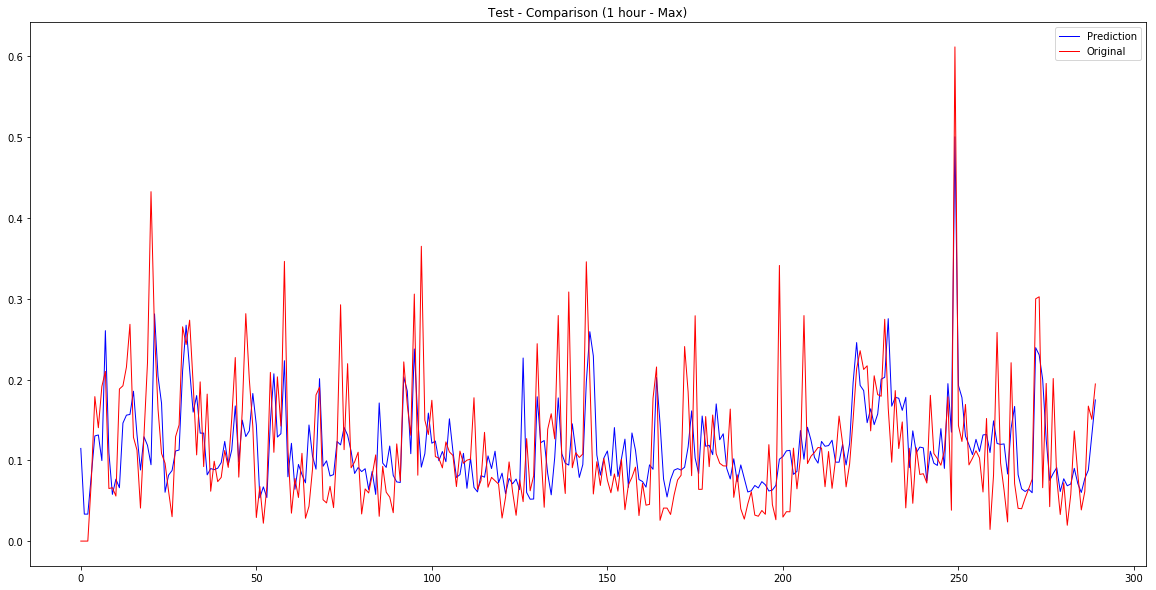

In [64]:
#1 timestep ahead has good prediction

pred_first = [item[4] for item in pred_x_test]
pred_first_first = [item[1] for item in pred_first] #0 = min, 1 = max
y_first = [item[4] for item in y_test]
y_first_first = [item[1] for item in y_first] #0 = min, 1 = max


# line_test_pred = np.reshape(pred_test, pred_test.shape[0])
# line_test_real = np.reshape(y_test_inv, y_test_inv.shape[0])
plt.figure(figsize=(20,10))
plt.plot(pred_first_first, color='blue',label='Prediction', linewidth=1)
plt.plot(y_first_first, color='red',label='Original', linewidth=1)
plt.legend(loc='best')
plt.title('Test - Comparison (1 hour - Max)')
plt.show()

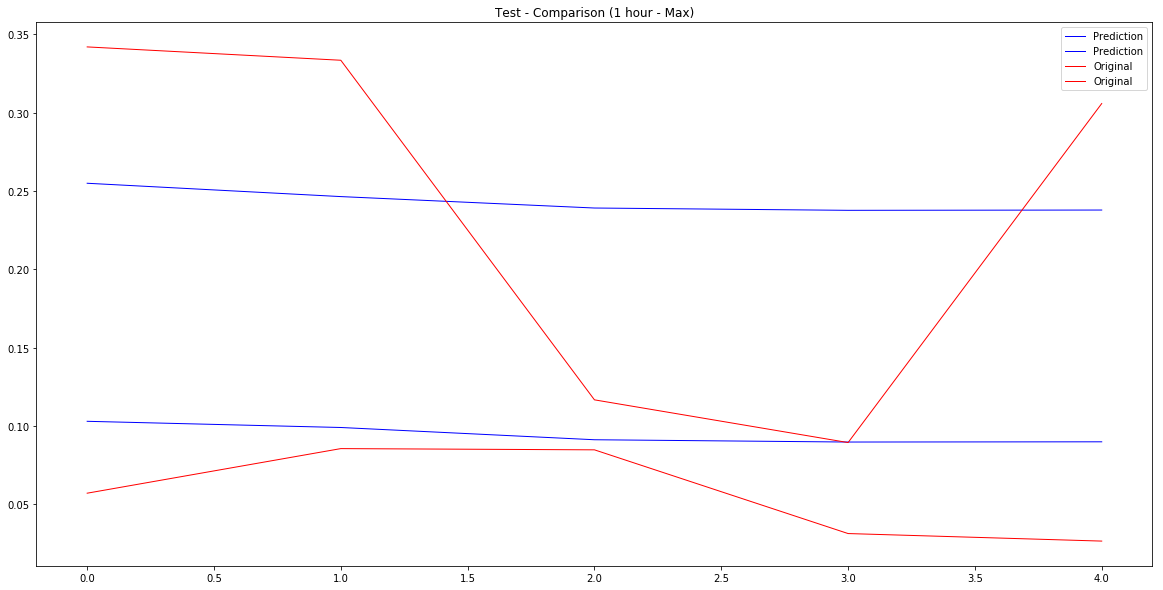

In [34]:
#1 timestep ahead has good prediction

pred_first_min = pred_x_test[95,:,0] #first predicted sample, min
pred_first_max = pred_x_test[95,:,1] #first predicted sample, max
y_first_min = y_test[95,:,0] #first sample, min
y_first_max = y_test[95,:,1] #first sample, max

plt.figure(figsize=(20,10))
plt.plot(pred_first_min, color='blue',label='Prediction', linewidth=1)
plt.plot(pred_first_max, color='blue',label='Prediction', linewidth=1)
plt.plot(y_first_min, color='red',label='Original', linewidth=1)
plt.plot(y_first_max, color='red',label='Original', linewidth=1)
plt.legend(loc='best')
plt.title('Test - Comparison (1 hour - Max)')
plt.show()

In [271]:
from keras.models import load_model

model_aggregated.save('model_aggregated_1hr.h5')

In [58]:
# returns a compiled model
# identical to the previous one
model_aggregated.load_weights('model_aggregated_1hr.h5')

In [68]:
scaler = MinMaxScaler(feature_range=(0,1))
scaler, X_train, Y_train, X_test, Y_test = train_test_aggregated_addfeatures(aggregated_1894_addfeatures, 
                                                                             "u'DENV--PNWG'", 0.93, 10, 5, scaler)

X_train shape:  (2700, 10, 6)
Y_train shape:  (2700, 5, 2)
X_test shape:  (203, 10, 6)
Y_test shape:  (203, 5, 2)


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [102]:
batch_size = 1
nb_epoch = 20

model_aggregated_addfeatures = Sequential()
model_aggregated_addfeatures.add(LSTM(input_dim = 6, output_dim=20, return_sequences=False))
model_aggregated_addfeatures.add(Dropout(0.2))
model_aggregated_addfeatures.add(RepeatVector(5)) #seq_len_y
model_aggregated_addfeatures.add(LSTM(output_dim=20, return_sequences=True))
model_aggregated_addfeatures.add(Dropout(0.2))
model_aggregated_addfeatures.add(TimeDistributed(Dense(2))) 

/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  """
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=20, return_sequences=False, input_shape=(None, 6))`
  """
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=20, return_sequences=True)`
  


In [103]:
print("-- Building --")
model_aggregated_addfeatures.compile(loss="mse",
                  optimizer = 'adam')

print('-- Training --')
for i in range(nb_epoch):
    model_aggregated_addfeatures.fit(X_train, Y_train, epochs=1, batch_size=batch_size, validation_data = (X_test, Y_test), 
                         shuffle=False)
    model_aggregated_addfeatures.reset_states()

-- Building --
-- Training --
Train on 2700 samples, validate on 203 samples
Epoch 1/1
2700/2700 [==============================] - 75s - loss: 0.0046 - val_loss: 0.0040
Train on 2700 samples, validate on 203 samples
Epoch 1/1
2700/2700 [==============================] - 74s - loss: 0.0039 - val_loss: 0.0036
Train on 2700 samples, validate on 203 samples
Epoch 1/1
2700/2700 [==============================] - 73s - loss: 0.0037 - val_loss: 0.0035
Train on 2700 samples, validate on 203 samples
Epoch 1/1
2700/2700 [==============================] - 73s - loss: 0.0037 - val_loss: 0.0035
Train on 2700 samples, validate on 203 samples
Epoch 1/1
2700/2700 [==============================] - 73s - loss: 0.0037 - val_loss: 0.0035
Train on 2700 samples, validate on 203 samples
Epoch 1/1
2700/2700 [==============================] - 74s - loss: 0.0036 - val_loss: 0.0035
Train on 2700 samples, validate on 203 samples
Epoch 1/1
2700/2700 [==============================] - 73s - loss: 0.0036 - val_los

In [104]:
# walk-forward validation on the test data
pred_x_test = model_aggregated_addfeatures.predict(X_test, batch_size)
print(pred_x_test.shape)
#pred_x_test = np.reshape(pred_x_test, (pred_x_test.shape[0]*pred_x_test.shape[1], 36))
#pred_test = inverse_transform(pred_x_test, scaler)

y_test = np.float_(Y_test)
#y_test = np.reshape(y_test, (y_test.shape[0]*y_test.shape[1], 36))
#y_test_inv = inverse_transform(y_test, scaler)

(203, 5, 2)


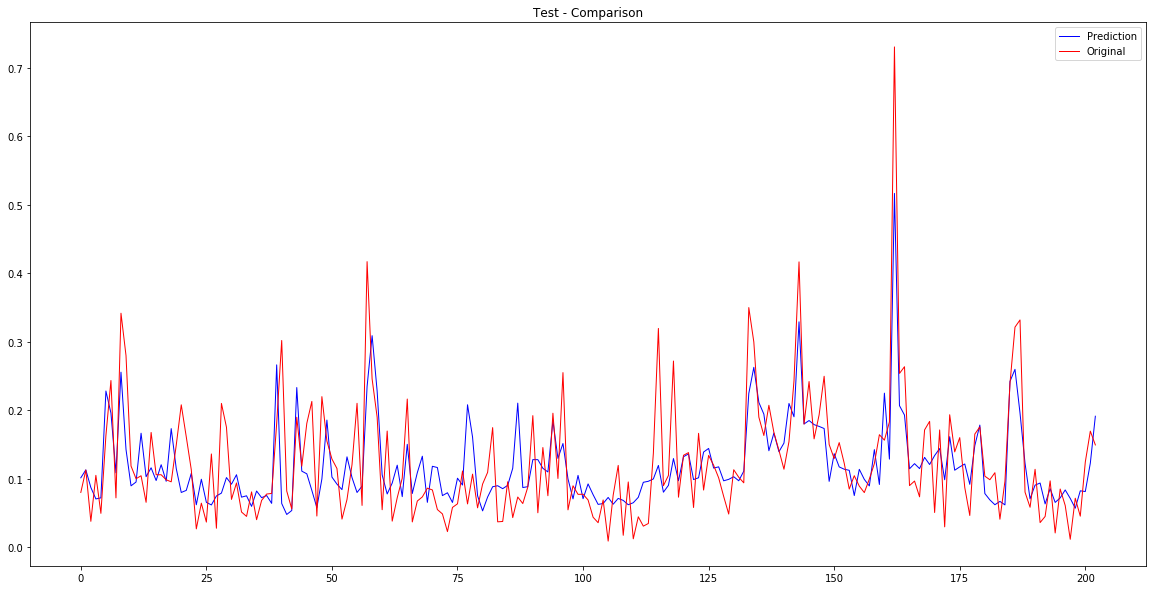

In [105]:
#1 timestep ahead has good prediction

pred_first = [item[0] for item in pred_x_test]
pred_first_first = [item[1] for item in pred_first] #0 = min, 1 = max
y_first = [item[0] for item in y_test]
y_first_first = [item[1] for item in y_first] #0 = min, 1 = max


# line_test_pred = np.reshape(pred_test, pred_test.shape[0])
# line_test_real = np.reshape(y_test_inv, y_test_inv.shape[0])
plt.figure(figsize=(20,10))
plt.plot(pred_first_first, color='blue',label='Prediction', linewidth=1)
plt.plot(y_first_first, color='red',label='Original', linewidth=1)
plt.legend(loc='best')
plt.title('Test - Comparison')
plt.show()

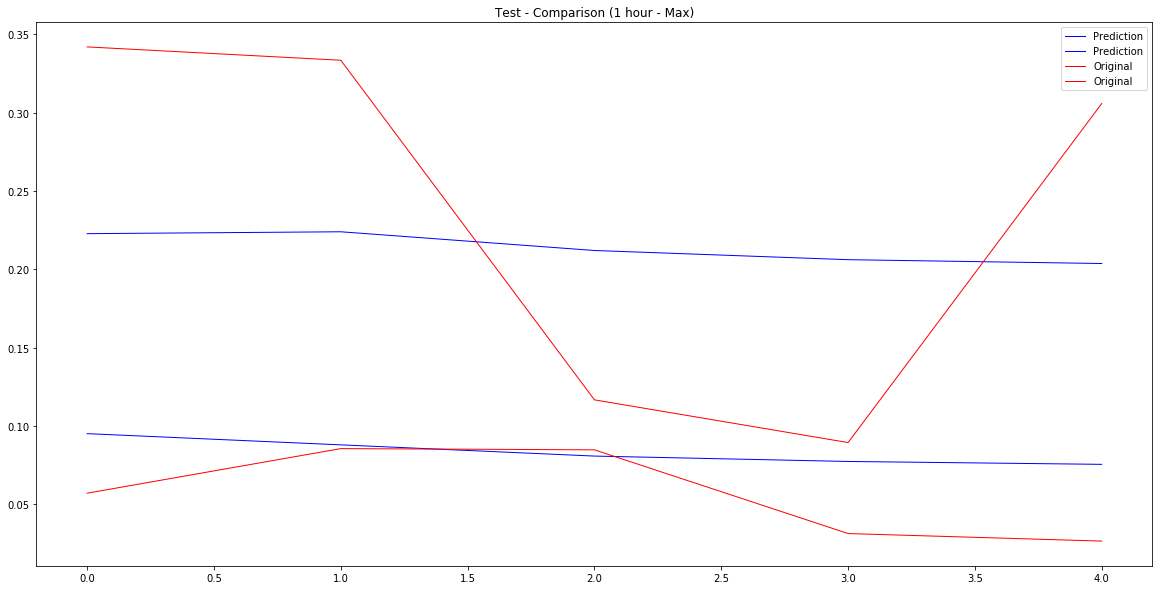

In [43]:
#1 timestep ahead has good prediction

pred_first_min = pred_x_test[95,:,0] #first predicted sample, min
pred_first_max = pred_x_test[95,:,1] #first predicted sample, max
y_first_min = y_test[95,:,0] #first sample, min
y_first_max = y_test[95,:,1] #first sample, max

plt.figure(figsize=(20,10))
plt.plot(pred_first_min, color='blue',label='Prediction', linewidth=1)
plt.plot(pred_first_max, color='blue',label='Prediction', linewidth=1)
plt.plot(y_first_min, color='red',label='Original', linewidth=1)
plt.plot(y_first_max, color='red',label='Original', linewidth=1)
plt.legend(loc='best')
plt.title('Test - Comparison (1 hour - Max)')
plt.show()

## Predicting max with all previous data

In [16]:
def train_test_allprevdata(train, target, pathway, split_proportion, seq_len_x, 
                          seq_len_y, scaler, traffic_scaler, print_shapes = True):
    
    indices = [i for i, s in enumerate(list(target.columns.values)) if pathway in s]
    
    X = train.drop('Time', axis = 1).as_matrix()
    X = scaler.fit_transform(X)
    
    Y = target.iloc[:,indices].as_matrix()
    Y = traffic_scaler.fit_transform(Y)
    
    result_X = []
    result_Y = []

    for index in range(0, Y.shape[0] - (seq_len_x + seq_len_y*10 + 1), seq_len_x + seq_len_y*10):
        result_X.append(X[index: index + seq_len_x]) 
        result_Y.append(Y[index + seq_len_x/20: index + seq_len_x/20 + seq_len_y,:])

    result_X = np.array(result_X)
    #result_X = result_X.reshape(result_X.shape[0], result_X[0].shape[0])
    result_Y = np.array(result_Y)
    #result_Y = result_Y.reshape(result_Y.shape[0], result_Y[0].shape[0])

    #Train-test split
    row = int(round(split_proportion * result_X.shape[0]))
    X_train = result_X[:row]
    Y_train = result_Y[:row]
    X_test = result_X[row:]
    Y_test = result_Y[row:]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X.shape[1]))
    #X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    #X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    Y_train = np.reshape(Y_train, (Y_train.shape[0], seq_len_y, 2))
    Y_test = np.reshape(Y_test, (Y_test.shape[0], seq_len_y, 2))
    #Y_train = Y_train.reshape(Y_train.shape[0], 1, Y_train.shape[1])
    #Y_test = Y_test.reshape(Y_test.shape[0], 1, Y_test.shape[1])

    if print_shapes:
        print("X_train shape: ", X_train.shape)
        print("Y_train shape: ", Y_train.shape)
        print("X_test shape: ", X_test.shape)
        print("Y_test shape: ", Y_test.shape)
    
    return scaler, traffic_scaler, X_train, Y_train, X_test, Y_test

In [205]:
scaler = MinMaxScaler(feature_range=(0,1))
traffic_scaler = MinMaxScaler(feature_range=(0,1))
scaler, traffic_scaler, X_train, Y_train, X_test, Y_test = train_test_allprevdata(points_1984_adddates, 
                                                                                  aggregated_1894, "u'DENV--PNWG'", 
                                                                                  0.9, 60, 5, scaler, 
                                                                                  traffic_scaler)

X_train shape:  (356, 60, 5)
Y_train shape:  (356, 5, 2)
X_test shape:  (39, 60, 5)
Y_test shape:  (39, 5, 2)


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:9: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if __name__ == '__main__':


In [208]:
batch_size = 1
nb_epoch = 50

model_aggregated_prevValues = Sequential()
model_aggregated_prevValues.add(LSTM(batch_input_shape = (1,60,5), output_dim=10, return_sequences=False))
#model_aggregated_prevValues.add(Dropout(0.2))
model_aggregated_prevValues.add(RepeatVector(5)) #seq_len_y
model_aggregated_prevValues.add(LSTM(output_dim=10, return_sequences=True))
#model_aggregated_prevValues.add(Dropout(0.2))
model_aggregated_prevValues.add(TimeDistributed(Dense(2))) 

/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=10, return_sequences=False, batch_input_shape=(1, 60, 5))`
  """
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=10, return_sequences=True)`
  


In [209]:
print("-- Building --")
model_aggregated_prevValues.compile(loss="mse",
                  optimizer = 'adam')

print('-- Training --')
for i in range(nb_epoch):
    model_aggregated_prevValues.fit(X_train, Y_train, epochs=1, batch_size=batch_size, validation_data = (X_test, Y_test), 
                         shuffle=True)
    model_aggregated_prevValues.reset_states()

-- Building --
-- Training --
Train on 356 samples, validate on 39 samples
Epoch 1/1
356/356 [==============================] - 29s - loss: 0.0071 - val_loss: 0.0064
Train on 356 samples, validate on 39 samples
Epoch 1/1
356/356 [==============================] - 27s - loss: 0.0061 - val_loss: 0.0062
Train on 356 samples, validate on 39 samples
Epoch 1/1
356/356 [==============================] - 28s - loss: 0.0060 - val_loss: 0.0067
Train on 356 samples, validate on 39 samples
Epoch 1/1
356/356 [==============================] - 27s - loss: 0.0061 - val_loss: 0.0061
Train on 356 samples, validate on 39 samples
Epoch 1/1
356/356 [==============================] - 27s - loss: 0.0060 - val_loss: 0.0061
Train on 356 samples, validate on 39 samples
Epoch 1/1
356/356 [==============================] - 28s - loss: 0.0060 - val_loss: 0.0065
Train on 356 samples, validate on 39 samples
Epoch 1/1
 43/356 [==>...........................] - ETA: 24s - loss: 0.0070

KeyboardInterrupt: 

# Aggregating 24 Hours

# Load Data

In [17]:
text_file = open('star-cr5.json')
lines = text_file.read().split('}')
text_file.close()

In [18]:
data = {}
for j in range(len(lines) - 1):
    data_day = json.loads(lines[j]+"}")
    int_keys = [int(key) for key in data_day.keys()]
    float_values = [float(value) for value in data_day.values()]
    for i in range(len(int_keys)):
        data[int_keys[i]] = float_values[i]

In [19]:
df = pd.DataFrame.from_dict(data, orient='index')
df.head()

,0
1470627840000,9.754329e+10
1490288640000,1.026986e+11
1525942020000,4.704042e+10
1509949440000,8.887512e+10
1493956860000,8.646035e+10


## Process Data

In [20]:
df.reset_index(level=0, inplace = True)
df.head()

,index,0
0,1470627840000,9.754329e+10
1,1490288640000,1.026986e+11
2,1525942020000,4.704042e+10
3,1509949440000,8.887512e+10
4,1493956860000,8.646035e+10


In [21]:
df.rename(index=str, columns = {'index': 'Time', 0:'STAR-CR5'}, inplace = True)
df['Time'] = df['Time'].astype('int64')
df['Time'] = df['Time'].apply(lambda x: datetime.fromtimestamp(x/1000.))
df.head()

,Time,STAR-CR5
0,2016-08-08 03:44:00,9.754329e+10
1,2017-03-23 17:04:00,1.026986e+11
2,2018-05-10 08:47:00,4.704042e+10
3,2017-11-06 06:24:00,8.887512e+10
4,2017-05-05 04:01:00,8.646035e+10


In [22]:
df.sort_values(by = ['Time'], inplace = True)
df.reset_index(inplace = True, drop = True)
df.head()

,Time,STAR-CR5
0,2016-01-01 00:01:00,3.613838e+08
1,2016-01-01 00:01:30,2.645857e+08
2,2016-01-01 00:02:00,2.423548e+08
3,2016-01-01 00:02:30,2.420286e+08
4,2016-01-01 00:03:00,3.526758e+08


In [23]:
df.shape

(2573422, 2)

In [141]:
df = df[(df['Time'] < '2017-10-17')]
df.head()

ValueError: cannot reindex from a duplicate axis

In [24]:
df['STAR-CR5'].isnull().sum()

23502

In [25]:
df[df.isnull().any(axis=1)]

,Time,STAR-CR5
2535089,2018-06-04 16:33:30,NaN
2535090,2018-06-04 16:34:00,NaN
2535091,2018-06-04 16:34:30,NaN
2535092,2018-06-04 16:35:00,NaN
2535093,2018-06-04 16:35:30,NaN
2535094,2018-06-04 16:36:00,NaN
2535095,2018-06-04 16:36:30,NaN
2535096,2018-06-04 16:37:00,NaN
2535097,2018-06-04 16:37:30,NaN
2535098,2018-06-04 16:38:00,NaN


In [26]:
mask = (df['STAR-CR5'].astype(str).str.len() < 15)
df = df.loc[mask]
print(df.shape)

(2573418, 2)


In [27]:
df.dropna(inplace = True)

In [28]:
aggregated_df = aggregate_data(df, 120)
aggregated_df.head()

,STAR-CR5_MIN,STAR-CR5_MAX
0,2.170111e+08,1.460990e+09
1,2.777272e+08,2.113267e+09
2,1.665361e+08,1.535692e+09
3,2.823661e+08,2.415220e+09
4,2.773305e+08,1.815698e+09


In [33]:
aggregated_df.shape

(21249, 2)

In [28]:
aggregated_df_addfeatures = aggregate_data_addfeatures(df, 120)
aggregated_df_addfeatures.head()

,LBL-MR2_MIN,LBL-MR2_MAX,LBL-MR2_MAXHOUR,LBL-MR2_MAXMINUTE,LBL-MR2_MINHOUR,LBL-MR2_MINMINUTE
0,3.395085e+08,1.371546e+10,0,21,0,20
1,5.244228e+08,9.583500e+09,1,16,1,58
2,4.065998e+08,1.029714e+10,2,21,2,17
3,4.450193e+08,1.092137e+10,3,40,3,38
4,4.657255e+08,7.876710e+09,4,31,4,55


## Model

In [48]:
def train_test_aggregated_24hrs_max(df, pathway, split_proportion, seq_len_x, seq_len_y, scaler, 
                                    traffic_scaler, print_shapes = True):
    
    indices = [i for i, s in enumerate(list(df.columns.values)) if pathway in s]
    
    X = df.iloc[:,indices].as_matrix()
    X = scaler.fit_transform(X)
    
    result_X = []
    result_Y = []

    for index in range(0, X.shape[0] - (seq_len_x + seq_len_y + 1), seq_len_y):
        result_X.append(X[index: index + seq_len_x]) 
        result_Y.append(X[index + seq_len_x: index + seq_len_x + seq_len_y])

    result_X = np.array(result_X)
    #result_X = result_X.reshape(result_X.shape[0], result_X[0].shape[0])
    result_Y = np.array(result_Y)
    #result_Y = result_Y.reshape(result_Y.shape[0], result_Y[0].shape[0])
    
    #result_X = scaler.fit_transform(result_X)
    #result_Y = traffic_scaler.fit_transform(result_Y)

    #Train-test split
    row = int(round(split_proportion * result_X.shape[0]))
    X_train = result_X[:row]
    Y_train = result_Y[:row]
    X_test = result_X[row:]
    Y_test = result_Y[row:]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(indices)))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], len(indices)))
    #X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    #X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    Y_train = np.reshape(Y_train, (Y_train.shape[0], Y_train.shape[1], 2))
    Y_test = np.reshape(Y_test, (Y_test.shape[0], Y_test.shape[1], 2))
    #Y_train = Y_train.reshape(Y_train.shape[0], 1, Y_train.shape[1])
    #Y_test = Y_test.reshape(Y_test.shape[0], 1, Y_test.shape[1])

    if print_shapes:
        print("X_train shape: ", X_train.shape)
        print("Y_train shape: ", Y_train.shape)
        print("X_test shape: ", X_test.shape)
        print("Y_test shape: ", Y_test.shape)
    
    return X_train, Y_train, X_test, Y_test

In [49]:
scaler = MinMaxScaler(feature_range=(0,1))
traffic_scaler = MinMaxScaler(feature_range=(0,1))
X_train, Y_train, X_test, Y_test = train_test_aggregated_24hrs_max(aggregated_df, 'STAR-CR5', 0.92, 
                                                                                           8, 8, scaler, traffic_scaler)

X_train shape:  (2442, 8, 2)
Y_train shape:  (2442, 8, 2)
X_test shape:  (212, 8, 2)
Y_test shape:  (212, 8, 2)


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [65]:
batch_size = 1
nb_epoch = 200 

model_aggregated_24hrs = Sequential()
model_aggregated_24hrs.add(LSTM(input_dim = 1, output_dim=64, return_sequences=False))
#model_aggregated_24hrs.add(Dropout(0.2))
model_aggregated_24hrs.add(RepeatVector(8)) #seq_len_y
model_aggregated_24hrs.add(LSTM(output_dim=64, return_sequences=True))
#model_aggregated_24hrs.add(Dropout(0.2))
model_aggregated_24hrs.add(TimeDistributed(Dense(1))) 

/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  """
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=64, return_sequences=False, input_shape=(None, 1))`
  """
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=64, return_sequences=True)`
  


In [65]:
print("-- Building --")
model_aggregated_24hrs.compile(loss="mse",
                  optimizer = 'adam')

print('-- Training --')
for i in range(nb_epoch):
    print("Epoch " + str(i + 1))
    model_aggregated_24hrs.fit(X_train, Y_train, epochs=1, batch_size=batch_size, validation_data = (X_test, Y_test), 
                         shuffle=False)
    model_aggregated_24hrs.reset_states()

-- Building --
-- Training --
Epoch 1
Train on 2457 samples, validate on 214 samples
Epoch 1/1
2457/2457 [==============================] - 69s - loss: 8.5739e-04 - val_loss: 2.0540e-04
Epoch 2
Train on 2457 samples, validate on 214 samples
Epoch 1/1
2457/2457 [==============================] - 69s - loss: 7.9908e-04 - val_loss: 2.0437e-04
Epoch 3
Train on 2457 samples, validate on 214 samples
Epoch 1/1
2457/2457 [==============================] - 69s - loss: 7.7564e-04 - val_loss: 1.9433e-04
Epoch 4
Train on 2457 samples, validate on 214 samples
Epoch 1/1
2457/2457 [==============================] - 69s - loss: 7.7264e-04 - val_loss: 2.0223e-04
Epoch 5
Train on 2457 samples, validate on 214 samples
Epoch 1/1
2457/2457 [==============================] - 70s - loss: 7.6114e-04 - val_loss: 1.9193e-04
Epoch 6
Train on 2457 samples, validate on 214 samples
Epoch 1/1
2457/2457 [==============================] - 69s - loss: 7.3246e-04 - val_loss: 1.8857e-04
Epoch 7
Train on 2457 samples, val

KeyboardInterrupt: 

In [103]:
batch_size = 1

# walk-forward validation on the test data
pred_x_test = model_aggregated_24hrs.predict(X_test, batch_size)
print(pred_x_test.shape)
#pred_x_test = np.reshape(pred_x_test, (pred_x_test.shape[0]*pred_x_test.shape[1], 36))
#pred_test = inverse_transform(pred_x_test, scaler)

y_test = np.float_(Y_test)
#y_test = np.reshape(y_test, (y_test.shape[0]*y_test.shape[1], 36))
#y_test_inv = inverse_transform(y_test, scaler)

(212, 8, 2)


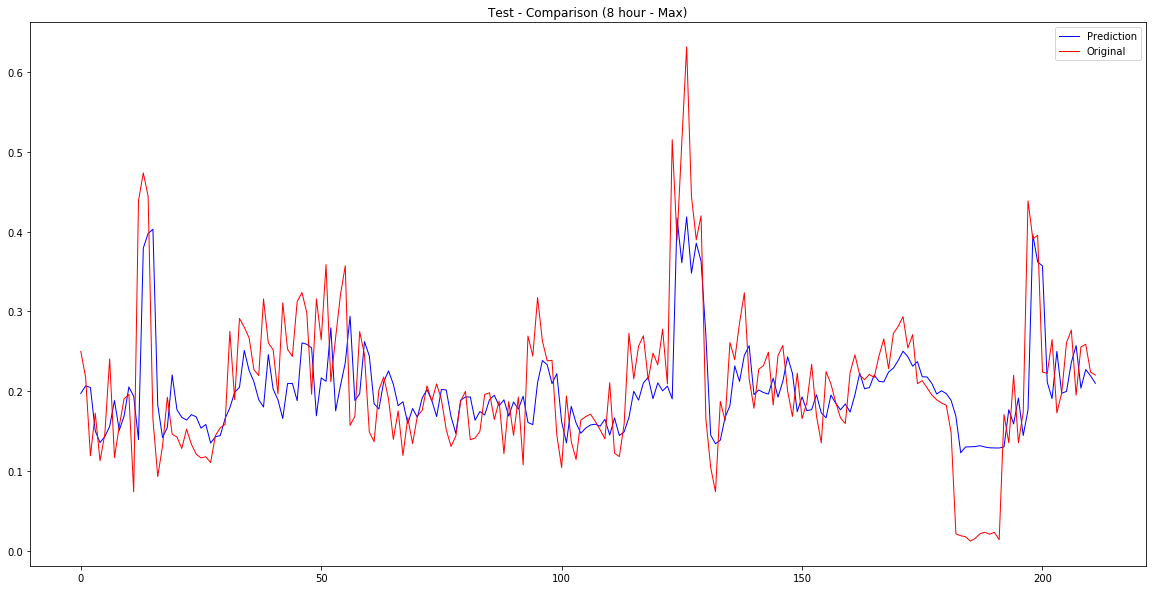

In [110]:
#1 timestep ahead has good prediction

pred_first = [item[7] for item in pred_x_test]
pred_first_first = [item[1] for item in pred_first] #0 = min, 1 = max
y_first = [item[7] for item in y_test]
y_first_first = [item[1] for item in y_first] #0 = min, 1 = max


# line_test_pred = np.reshape(pred_test, pred_test.shape[0])
# line_test_real = np.reshape(y_test_inv, y_test_inv.shape[0])
plt.figure(figsize=(20,10))
plt.plot(pred_first_first, color='blue',label='Prediction', linewidth=1)
plt.plot(y_first_first, color='red',label='Original', linewidth=1)
plt.legend(loc='best')
plt.title('Test - Comparison (8 hour - Max)')
plt.show()

In [101]:
#star-cr5
model_aggregated_24hrs.evaluate(X_test, Y_test)

 32/214 [===>..........................] - ETA: 0s

0.0037599511696983163

In [248]:
from keras.models import load_model

model_aggregated_24hrs.save('model_aggregated_8hrs_cern-272-cr5.h5')

In [102]:
from keras.models import load_model
# returns a compiled model
# identical to the previous one
model_aggregated_24hrs = load_model('model_aggregated_8hrs_star-cr5.h5')

model_aggregated_24hrs.compile(loss="mse",
                  optimizer = 'adam')

In [30]:
aggregated_df.head()

,STAR-CR5_MIN,STAR-CR5_MAX
0,2.170111e+08,1.460990e+09
1,2.777272e+08,2.113267e+09
2,1.665361e+08,1.535692e+09
3,2.823661e+08,2.415220e+09
4,2.773305e+08,1.815698e+09


In [31]:
aggregated_df_totsv = aggregated_df.copy()
aggregated_df_totsv.index = df.iloc[range(120,df.shape[0],120),0]
aggregated_df_totsv.index.rename("date", inplace = True)
aggregated_df_totsv.head()

,STAR-CR5_MIN,STAR-CR5_MAX
date,,
2016-01-01 01:01:00,2.170111e+08,1.460990e+09
2016-01-01 02:01:00,2.777272e+08,2.113267e+09
2016-01-01 03:01:00,1.665361e+08,1.535692e+09
2016-01-01 04:01:00,2.823661e+08,2.415220e+09
2016-01-01 05:01:00,2.773305e+08,1.815698e+09


In [31]:
aggregated_df_totsv.to_csv("cern-513-asw1.tsv", sep = "\t", float_format='%.0f')

In [32]:
scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(aggregated_df.as_matrix())

aggregated_df_tojson = pd.DataFrame(data = X)
aggregated_df_tojson.index = df.iloc[range(120,df.shape[0],120),0]
aggregated_df_tojson.index.rename("date", inplace = True)
aggregated_df_tojson.rename(columns={0:'STAR-CR5_MIN', 1:'STAR-CR5_MAX'}, inplace = True)
aggregated_df_tojson.head()

/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


,STAR-CR5_MIN,STAR-CR5_MAX
date,,
2016-01-01 01:01:00,0.000447,0.001972
2016-01-01 02:01:00,0.000572,0.002852
2016-01-01 03:01:00,0.000343,0.002073
2016-01-01 04:01:00,0.000582,0.003260
2016-01-01 05:01:00,0.000571,0.002451


In [33]:
import json

#store data in dict
data_min = {}
data_min["start"] = aggregated_df_tojson.iloc[0].name.strftime('%Y-%m-%d %H:%M:%S') #add start date in str format
data_min["target"] = [aggregated_df_tojson.iloc[0,0]] #add min traffic values at start date

data_max = {}
data_max["start"] = aggregated_df_tojson.iloc[0].name.strftime('%Y-%m-%d %H:%M:%S')
data_max["target"] = [aggregated_df_tojson.iloc[0,1]] #add min traffic values at start date

#append rest of the traffiv values
for i in range(1, aggregated_df_tojson.shape[0]):
    data_min["target"].append(aggregated_df_tojson.iloc[i,0]) 
    data_max["target"].append(aggregated_df_tojson.iloc[i,1])

#open file and dump data
with open("star-cr5-deepar.json", "wb") as f:
    f.write(json.dumps(data_min).encode("utf-8")) #write to json file
    f.write("\n".encode("utf-8"))
    f.write(json.dumps(data_max).encode("utf-8"))
    
# Close opened file
f.close()

## Download Predictions

In [32]:
pred_df = pd.DataFrame({})
pathway = "STAR-CR5"

for i in range(8):
    pred_future_val = [item[i] for item in pred_x_test]
    y_future_val = [item[i] for item in y_test]
    for j in range(1):
        #Max or min 
        title = "MIN"
        if j==1:
            title = "MAX"
        
        #Get arrays from true and predicted
        pred_min_max = [item[j] for item in pred_future_val]
        y_min_max = [item[j] for item in y_future_val]
        
        #Pad with 0's
        pred_min_max = pred_min_max + [0]*(8-i)
        y_min_max = y_min_max + [0]*(8-i)
        
        pred_min_max = [0]*i + pred_min_max
        y_min_max = [0]*i + y_min_max
        
        #Add to DataFrame
        pred_df[pathway+"_PRED_STEP-"+str(i+1)+"_"+title] = pred_min_max
        pred_df[pathway+"_TRUE_STEP-"+str(i+1)+"_"+title] = y_min_max
        
print(len(pred_df['WASH-CR5_PRED_STEP-1_MIN']))

#Add dates
dates = aggregated_df_totsv.iloc[range(2279*8, aggregated_df.shape[0] - (8 + 8 + 1), 8),:].index.values
#pred_df['date'] = dates

pred_df.head()

NameError: name 'pred_x_test' is not defined

In [105]:
pred_df = pd.DataFrame({})
pathway = "LBL-MR2"

pred_min = []
pred_max = []
y_min = []
y_max = []
for item in pred_x_test:
    pred_min = pred_min + [number[0] for number in item]
    pred_max = pred_max + [number[1] for number in item]
for item in y_test:
    y_min = y_min + [number[0] for number in item]
    y_max = y_max + [number[1] for number in item]

pred_df[pathway+'_Predicted_Min'] = pred_min
pred_df[pathway+'_Predicted_Max'] = pred_max
pred_df[pathway+'_Truth_Min'] = y_min
pred_df[pathway+'_Truth_Max'] = y_max
print(pred_df.shape)

dates = aggregated_df_totsv.iloc[range(2457*8, aggregated_df_totsv.shape[0] - (8 + 10 - 1)),:].index.values
pred_df.index = dates
pred_df.index.rename("date", inplace = True)

pred_df.head()

(1712, 4)


,LBL-MR2_Predicted_Min,LBL-MR2_Predicted_Max,LBL-MR2_Truth_Min,LBL-MR2_Truth_Max
date,,,,
2018-04-06 19:15:30,0.006806,0.262437,0.005143,0.249145
2018-04-06 20:15:30,0.009525,0.264337,0.005984,0.277878
2018-04-06 21:15:30,0.008876,0.268517,0.006420,0.232408
2018-04-06 22:15:30,0.008924,0.270429,0.004855,0.319253
2018-04-06 23:15:30,0.009081,0.271394,0.004927,0.254965


In [106]:
pred_df.to_csv("lbl-mr2_pred.tsv", sep = "\t", float_format='%.6f')

In [117]:
pred_df = pd.DataFrame({})
pathway = "CERN-513-ASW1"

#pred_min = []
pred_max = []
#y_min = []
y_max = []
for item in pred_x_test:
    #pred_min = pred_min + [number[0] for number in item]
    #pred_max = pred_max + [number[1] for number in item]
    pred_max = pred_max + item.tolist()
for item in y_test:
    #y_min = y_min + [number[0] for number in item]
    #y_max = y_max + [number[1] for number in item]
    y_max = y_max + item.tolist()

    
#pred_df[pathway+'_Predicted_Min'] = pred_min
pred_df[pathway+'_Predicted_Max'] = pred_max
#pred_df[pathway+'_Truth_Min'] = y_min
pred_df[pathway+'_Truth_Max'] = y_max
print(pred_df.shape)

pred_df = pd.concat((pd.DataFrame(pred_df[pathway+'_Predicted_Max'].tolist()), pd.DataFrame(pred_df[pathway+'_Truth_Max'].tolist())), axis=1)
pred_df.rename(columns={0:pathway+'_Predicted_Max', 0:pathway+'_Truth_Max'}, inplace = True)

dates = aggregated_df_totsv.iloc[range(2279*8, aggregated_df_totsv.shape[0] - (8 + 6 - 1)),:].index.values
pred_df.index = dates
pred_df.index.rename("date", inplace = True)

pred_df.head()

(1584, 2)


,ALBQ-ASW1_Truth_Max,ALBQ-ASW1_Truth_Max
date,,
2018-04-08 12:07:30,0.208777,0.242247
2018-04-08 13:07:30,0.168745,0.000004
2018-04-08 14:07:30,0.241015,0.000003
2018-04-08 15:07:30,0.293272,0.329622
2018-04-08 16:07:30,0.321629,0.347716


In [118]:
pred_df.to_csv("albq-asw1_pred-max.tsv", sep = "\t", float_format='%.6f')

## ARIMA Baseline

In [29]:
from statsmodels.tsa.arima_model import ARIMA

In [30]:
scaler = MinMaxScaler(feature_range=(0,1))
row = 2455*8
aggregated_df_scaled = scaler.fit_transform(aggregated_df)
X_train = aggregated_df_scaled[0:row,0]
X_test = aggregated_df_scaled[row:,0]

In [31]:
preds = []
j = 1
for i in range(0, 214*8, 8): #len(X_test) from train_test_aggregated_24hrs_max
    print(j)
    model = ARIMA(X_train[0:row+i], order=(8,0,2))
    model_fit = model.fit(disp=0)
    # multi-step out-of-sample forecast
    forecast = model_fit.forecast(steps=8)[0]
    history = []
    day = 1
    for yhat in forecast:
        history.append(yhat)
        day += 1
    preds.append(history)
    j+=1

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214


In [33]:
result_Y = []
for index in range(0, X_test.shape[0] - 17, 8):
    result_Y.append(X_test[index:index + 8])
print(np.array(result_Y).shape)

print(np.array(preds).shape)

(214, 8)
(214, 8)


In [34]:
def mserror(y, y_pred):
    mse = []
    for i in range (len(y)):
        mse_i = np.mean((y[i] - y_pred[i]) ** 2)
        mse.append(mse_i)
    return np.mean(mse)

In [35]:
mserror(np.array(result_Y), np.array(preds))

0.011980836708085202

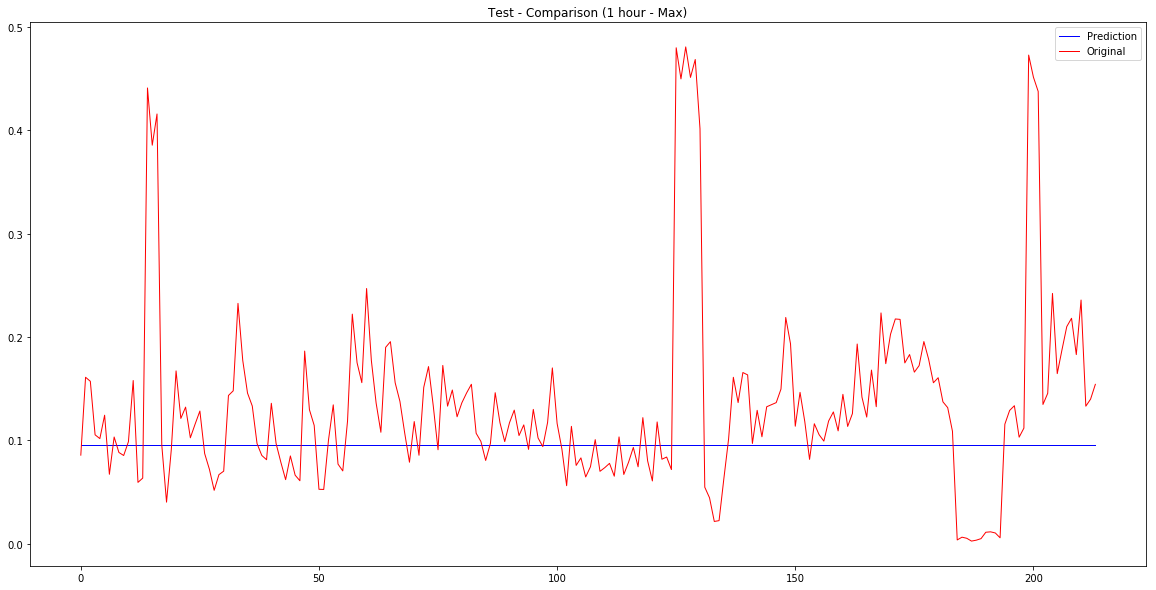

In [121]:
#1 timestep ahead has good prediction

pred_first = [item[0] for item in preds]
#pred_first_first = [item[0] for item in pred_first] #0 = min, 1 = max
y_first = [item[0] for item in result_Y]
#y_first_first = [item[0] for item in y_first] #0 = min, 1 = max


# line_test_pred = np.reshape(pred_test, pred_test.shape[0])
# line_test_real = np.reshape(y_test_inv, y_test_inv.shape[0])
plt.figure(figsize=(20,10))
plt.plot(pred_first, color='blue',label='Prediction', linewidth=1)
plt.plot(y_first, color='red',label='Original', linewidth=1)
plt.legend(loc='best')
plt.title('Test - Comparison (1 hour - Max)')
plt.show()